**Load the required libraries and data**

In [ ]:
# # Load the required libraries 
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
# import matplotlib.pyplot as plt
# import seaborn as sns

In [ ]:
# # --- Assumptions ---
# # pred_df should have columns: filename, predicted_label, confidence
# # anno_df should have columns: filename, label
# # You may need to adjust column names as per your actual data

# # Merge on filename (or image_id if more appropriate)
# merged = pd.merge(pred_df, anno_df[['filename', 'label']], on='filename', how='inner', suffixes=('_pred', '_true'))

# # If pred_df has a confidence column, use it for thresholding
# thresholds = np.linspace(0, 1, 21)
# metrics = []

# for thresh in thresholds:
#     # Assume binary classification: 1 = defect, 0 = no defect
#     # Adjust as needed for multiclass
#     merged['pred_bin'] = (merged['confidence'] >= thresh).astype(int)
#     merged['true_bin'] = (merged['label'] != 'no defect').astype(int)  # Adjust if your negative class is named differently

#     acc = accuracy_score(merged['true_bin'], merged['pred_bin'])
#     prec = precision_score(merged['true_bin'], merged['pred_bin'], zero_division=0)
#     rec = recall_score(merged['true_bin'], merged['pred_bin'], zero_division=0)
#     f1 = f1_score(merged['true_bin'], merged['pred_bin'], zero_division=0)
#     metrics.append([thresh, acc, prec, rec, f1])

# metrics_df = pd.DataFrame(metrics, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1'])

# # Plot metrics vs. threshold
# plt.figure(figsize=(10,6))
# plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], label='Accuracy')
# plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision')
# plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall')
# plt.plot(metrics_df['Threshold'], metrics_df['F1'], label='F1-score')
# plt.xlabel('Confidence Threshold')
# plt.ylabel('Score')
# plt.title('Metrics vs. Confidence Threshold')
# plt.legend()
# plt.show()

# # Confusion matrix at optimal threshold (e.g., max F1)
# best_idx = metrics_df['F1'].idxmax()
# best_thresh = metrics_df.loc[best_idx, 'Threshold']
# merged['pred_bin'] = (merged['confidence'] >= best_thresh).astype(int)
# cm = confusion_matrix(merged['true_bin'], merged['pred_bin'])

# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title(f'Confusion Matrix (Threshold={best_thresh:.2f})')
# plt.show()

# # ROC Curve
# fpr, tpr, _ = roc_curve(merged['true_bin'], merged['confidence'])
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(6,5))
# plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0,1], [0,1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()

# # Precision-Recall Curve
# prec, rec, _ = precision_recall_curve(merged['true_bin'], merged['confidence'])
# plt.figure(figsize=(6,5))
# plt.plot(rec, prec, label='Precision-Recall curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend()
# plt.show()
# # ...existing code...

In [ ]:
import pandas as pd
import ast
from shapely.geometry import Polygon

In [ ]:
# Load data
anno_df = pd.read_csv('../data/clean-data/anno_df_clean.csv')
pred_df = pd.read_csv('../data/clean-data/pred_df_clean.csv')

In [ ]:
anno_df["xy"] = anno_df["xy"].apply(ast.literal_eval)
pred_df["xy"] = pred_df["xy"].apply(ast.literal_eval)

In [ ]:
def parse_xy(xy_str):
    # Implement parsing logic depending on your format
    # Example: if xy_str is 'x1,y1;x2,y2;...'
    return [tuple(map(float, point.split(','))) for point in xy_str.split(';')]

# def iou(poly1, poly2):
#     # Compute Intersection over Union using shapely
#     p1 = Polygon(poly1)
#     p2 = Polygon(poly2)
#     if not p1.is_valid or not p2.is_valid:
#         return 0.0
#     inter = p1.intersection(p2).area
#     union = p1.union(p2).area
#     return inter / union if union > 0 else 0

def iou(poly1, poly2):
    # Convert flat list to list of (x, y) tuples if needed
    if isinstance(poly1[0], (int, float)):
        poly1 = list(zip(poly1[::2], poly1[1::2]))
    if isinstance(poly2[0], (int, float)):
        poly2 = list(zip(poly2[::2], poly2[1::2]))
    p1 = Polygon(poly1)
    p2 = Polygon(poly2)
    if not p1.is_valid or not p2.is_valid:
        return 0
    inter = p1.intersection(p2).area
    union = p1.union(p2).area
    return inter / union if union > 0 else 0

In [ ]:
# Set IoU threshold for a match
IOU_THRESHOLD = 0.5

TP = 0
FP = 0
FN = 0

In [ ]:
for image_id in anno_df['image_id'].unique():
    gt_polys = anno_df[anno_df['image_id'] == image_id]['xy'].apply(parse_xy).tolist()
    pred_polys = pred_df[pred_df['image_id'] == image_id]['xy'].apply(parse_xy).tolist()
    
    matched_gt = set()
    matched_pred = set()
    
    for pred_idx, pred_poly in enumerate(pred_polys):
        found_match = False
        for gt_idx, gt_poly in enumerate(gt_polys):
            if gt_idx in matched_gt:
                continue
            if iou(pred_poly, gt_poly) >= IOU_THRESHOLD:
                TP += 1
                matched_gt.add(gt_idx)
                matched_pred.add(pred_idx)
                found_match = True
                break
        if not found_match:
            FP += 1
    FN += len(gt_polys) - len(matched_gt)

In [ ]:
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

In [ ]:
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

# New Implementation - Calculate standard metrics
**Confidence Value is the threshold value when accounting for TP, FP and FN**

In [44]:
# Load the required libraries 
import ast
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import seaborn as sns 
import warnings

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

In [2]:
# Load the cleaned CSVs
anno_df = pd.read_csv('../data/clean-data/anno_df_clean.csv')   # Manual annotations
pred_df = pd.read_csv('../data/clean-data/pred_df_clean.csv')   # Model predictions

In [3]:
# Keep only predictions for images that have manual annotations
filtered_pred_df = pred_df[pred_df['image_id'].isin(anno_df['image_id'])]

filtered_pred_df.head()

,image_id,prediction_id,confidence,polygon_id,xy
0,3165,23699,0.431523,1937097,"37.578460693359375,13.887542724609375,37.31016..."
1,3165,23699,0.603884,1937098,"231.45407104492188,9.646164820744442,225.45407..."
2,3165,23699,0.244653,1937099,"318.3146711077009,33.736045837402344,316.76688..."
3,3165,23699,0.916268,1937100,"395.9158020019531,82.97906857445126,387.915802..."
4,3165,23699,0.366087,1937101,"337.0517883300781,84.71218928584346,332.051788..."


In [4]:
anno_df.head()

,filename,image_id,id,xy,x,y
0,1g_04.png,624,175683,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,...","[1354.0, 1330.52, 1330.52, 1350.087, 1357.913,...","[1377.48, 1389.22, 1412.699, 1424.439, 1420.52..."
1,1g_04.png,624,175664,"223.058,1804.029,199.578,1800.116,191.751,1815...","[223.058, 199.578, 191.751, 203.491, 223.058, ...","[1804.029, 1800.116, 1815.769, 1831.422, 1835...."
2,1g_04.png,624,175634,"1549.665,1005.717,1545.751,1013.543,1541.838,1...","[1549.665, 1545.751, 1541.838, 1541.838, 1557....","[1005.717, 1013.543, 1021.37, 1037.023, 1037.0..."
3,1g_04.png,624,175654,"661.347,1678.803,637.867,1667.064,614.387,1674...","[661.347, 637.867, 614.387, 622.214, 630.04, 6...","[1678.803, 1667.064, 1674.89, 1698.37, 1694.45..."
4,1g_04.png,624,175633,"1784.462,1897.948,1796.202,1886.208,1804.029,1...","[1784.462, 1796.202, 1804.029, 1780.549, 1772....","[1897.948, 1886.208, 1870.555, 1858.815, 1862...."


In [5]:
# Get the features that will matter from the manual 
anno_df = anno_df[['image_id', 'id', 'xy']]
anno_df.head()

,image_id,id,xy
0,624,175683,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,..."
1,624,175664,"223.058,1804.029,199.578,1800.116,191.751,1815..."
2,624,175634,"1549.665,1005.717,1545.751,1013.543,1541.838,1..."
3,624,175654,"661.347,1678.803,637.867,1667.064,614.387,1674..."
4,624,175633,"1784.462,1897.948,1796.202,1886.208,1804.029,1..."


In [6]:
# Merge on 'image_id' to pair manual and predicted for each image
merged_df = pd.merge(
    anno_df, filtered_pred_df,
    on='image_id',
    suffixes=('_manual', '_predicted')
)

# Preview the edits 
merged_df.head()

,image_id,id,xy_manual,prediction_id,confidence,polygon_id,xy_predicted
0,624,175683,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,...",23746,0.459061,1943470,"529.6653366088867,394.1354550962095,522.665336..."
1,624,175683,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,...",23746,0.862112,1943471,"564.6947244497446,1107.9412689208984,556.54087..."
2,624,175683,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,...",23746,0.455114,1943472,"548.7361194776452,1158.1390075683594,550.40501..."
3,624,175683,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,...",23746,0.256400,1943473,"524.8235282897949,1337.475,535.8235282897949,1..."
4,624,175683,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,...",23746,0.725020,1943474,"506.43187522888184,1372.9502636137463,500.7483..."


In [7]:
merged_df.shape

(695494, 7)

In [8]:
# Pair the xy coordinates for shapely 

def parse_xy(xy_str):
    # If already a list, return as is
    if isinstance(xy_str, list):
        return xy_str
    # If string, parse to list of tuples
    coords = ast.literal_eval(xy_str) if isinstance(xy_str, str) else xy_str
    # If flat list, pair into tuples
    if coords and isinstance(coords[0], (int, float)):
        return [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
    return coords

merged_df['xy_manual'] = merged_df['xy_manual'].apply(parse_xy)
merged_df['xy_predicted'] = merged_df['xy_predicted'].apply(parse_xy)

# Preview the edits 
merged_df.head()

,image_id,id,xy_manual,prediction_id,confidence,polygon_id,xy_predicted
0,624,175683,"[(1354, 1377.48), (1330.52, 1389.22), (1330.52...",23746,0.459061,1943470,"[(529.6653366088867, 394.1354550962095), (522...."
1,624,175683,"[(1354, 1377.48), (1330.52, 1389.22), (1330.52...",23746,0.862112,1943471,"[(564.6947244497446, 1107.9412689208984), (556..."
2,624,175683,"[(1354, 1377.48), (1330.52, 1389.22), (1330.52...",23746,0.455114,1943472,"[(548.7361194776452, 1158.1390075683594), (550..."
3,624,175683,"[(1354, 1377.48), (1330.52, 1389.22), (1330.52...",23746,0.256400,1943473,"[(524.8235282897949, 1337.475), (535.823528289..."
4,624,175683,"[(1354, 1377.48), (1330.52, 1389.22), (1330.52...",23746,0.725020,1943474,"[(506.43187522888184, 1372.9502636137463), (50..."


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [9]:
# # Compute Intersection union from the polygon coordinates 

# def compute_iou(row):
#     poly_manual = Polygon(row['xy_manual'])
#     poly_pred = Polygon(row['xy_predicted'])
#     if not poly_manual.is_valid or not poly_pred.is_valid:
#         return 0.0
#     intersection = poly_manual.intersection(poly_pred).area
#     union = poly_manual.union(poly_pred).area
#     return intersection / union if union > 0 else 0.0

# merged_df['iou'] = merged_df.apply(compute_iou, axis=1)
# merged_df.head()

In [10]:
# # Manual computation 

# ## extract the first row
# poly_manual = Polygon(merged_df['xy_manual'][0])
# poly_manual

In [11]:
# poly_pred = Polygon(merged_df['xy_predicted'][0])
# poly_pred

In [12]:
# intersection = poly_manual.intersection(poly_pred).area
# intersection

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [13]:
from shapely.geometry import Polygon

def calculate_polygon_iou(polygon1_coords, polygon2_coords):
    """
    Calculates the Intersection over Union (IoU) of two polygons.

    Args:
        polygon1_coords (list of tuples): A list of (x, y) coordinates
                                          representing the vertices of the first polygon.
        polygon2_coords (list of tuples): A list of (x, y) coordinates
                                          representing the vertices of the second polygon.

    Returns:
        float: The IoU value between the two polygons. Returns 0.0 if the union area is zero.
    """
    # Create Shapely Polygon objects
    polygon1 = Polygon(polygon1_coords)
    polygon2 = Polygon(polygon2_coords)

    # Check polygon validity and fix 
    if polygon1.is_valid==False: 
        polygon1 = polygon1.buffer(0)
    else: 
        pass

    if polygon2.is_valid==False: 
        polygon2 = polygon2.buffer(0)
    else: 
        pass

    # Calculate the intersection area
    intersection_area = polygon1.intersection(polygon2).area

    # Calculate the union area
    union_area = polygon1.union(polygon2).area

    # Calculate IoU
    if union_area > 0:
        iou = intersection_area / union_area
    else:
        iou = 0.0  # Avoid division by zero if polygons don't overlap and have no area

    return iou

# Example Usage:
# Define polygon coordinates
poly1_coords = [(0, 0), (0, 2), (2, 2), (2, 0)]  # A square
poly2_coords = [(1, 1), (1, 3), (3, 3), (3, 1)]  # Another square, overlapping

iou_value = calculate_polygon_iou(poly1_coords, poly2_coords)
print(f"IoU between the two polygons: {iou_value}")

# Example with non-overlapping polygons
poly3_coords = [(0, 0), (0, 1), (1, 1), (1, 0)]
poly4_coords = [(2, 2), (2, 3), (3, 3), (3, 2)]

iou_non_overlapping = calculate_polygon_iou(poly3_coords, poly4_coords)
print(f"IoU between non-overlapping polygons: {iou_non_overlapping}")

IoU between the two polygons: 0.14285714285714285
IoU between non-overlapping polygons: 0.0


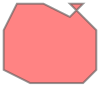

In [14]:
Polygon(merged_df["xy_manual"][6372])

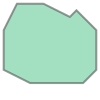

In [15]:
Polygon(merged_df["xy_manual"][6372]).buffer(0)

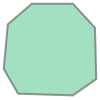

In [16]:
Polygon(merged_df["xy_predicted"][6372])

In [17]:
# Remove any errors in calculations 

iou_list = []

error_count = 0

# Iterate through every row in merged dataset 
for i in range(merged_df.shape[0]):
    # Declare the coordinates
    polygon1_coords = merged_df["xy_manual"][i]
    polygon2_coords = merged_df["xy_predicted"][i]
    # Calculate iou
    try: 
        iou_value = calculate_polygon_iou(polygon1_coords, polygon2_coords)
        iou_list.append(iou_value)
    except ValueError: 
        print(f"{i}: not polygon")
        error_count +=1

        # Set iou to zero
        iuo_value = 0
        iou_list.append(iou_value)
    # Catch future errors - self-intersecting polygon erros are fixed
    except GEOSException as e:            
        print(f"GEOSException at index: {i}")
        error_count +=1
        iou_value = 0
        iou_list.append(iou_value)

print(f"Error count: {error_count}")

454361: not polygon
454362: not polygon
454363: not polygon
454364: not polygon
454365: not polygon
454366: not polygon
454367: not polygon
454368: not polygon
454369: not polygon
454370: not polygon
454371: not polygon
454372: not polygon
454373: not polygon
454374: not polygon
454375: not polygon
454376: not polygon
454377: not polygon
454378: not polygon
454379: not polygon
454380: not polygon
454381: not polygon
454382: not polygon
454383: not polygon
454384: not polygon
454385: not polygon
Error count: 25


In [18]:
merged_df["xy_manual"][454385]

[(632.526, 421.684)]

In [19]:
# find number of unmatched instances due to merging by image id
iou_list.count(0)

691940

In [20]:
# Find the count matched instances
len(iou_list)-iou_list.count(0)

3554

In [21]:
# add a new column of IoU  
merged_df["IoU"] = iou_list

# drop all rows there Iou = 0 -- Unmatched instances
df = merged_df[merged_df["IoU"] != 0].reset_index(drop=True)
df.head()

,image_id,id,xy_manual,prediction_id,confidence,polygon_id,xy_predicted,IoU
0,624,175683,"[(1354, 1377.48), (1330.52, 1389.22), (1330.52...",23746,0.932983,1943517,"[(1328.6110534667969, 1405.1416015625), (1332....",0.891768
1,624,175664,"[(223.058, 1804.029), (199.578, 1800.116), (19...",23746,0.626765,1943484,"[(222.66780180089614, 1832.8301467895508), (22...",0.771366
2,624,175634,"[(1549.665, 1005.717), (1545.751, 1013.543), (...",23746,0.863642,1943533,"[(1545.576050652398, 1003.3963088989258), (153...",0.765831
3,624,175654,"[(661.347, 1678.803), (637.867, 1667.064), (61...",23746,0.938495,1943522,"[(643.3214721679688, 1633.8008189481848), (639...",0.505843
4,624,175633,"[(1784.462, 1897.948), (1796.202, 1886.208), (...",23746,0.260624,1943544,"[(1782.8247375488281, 1858.7501768224379), (17...",0.639641


In [22]:
df.shape

(3554, 8)

In [23]:
# Use the confidence value from the prediction as threshold
df['tp'] = (df['IoU'] >= df['confidence']).astype(int)
df['fp'] = (df['IoU'] < df['confidence']).astype(int)
# For FN, you would need to check for manual annotations with no predictions (not in df)

In [24]:
df.head()

,image_id,id,xy_manual,prediction_id,confidence,polygon_id,xy_predicted,IoU,tp,fp
0,624,175683,"[(1354, 1377.48), (1330.52, 1389.22), (1330.52...",23746,0.932983,1943517,"[(1328.6110534667969, 1405.1416015625), (1332....",0.891768,0,1
1,624,175664,"[(223.058, 1804.029), (199.578, 1800.116), (19...",23746,0.626765,1943484,"[(222.66780180089614, 1832.8301467895508), (22...",0.771366,1,0
2,624,175634,"[(1549.665, 1005.717), (1545.751, 1013.543), (...",23746,0.863642,1943533,"[(1545.576050652398, 1003.3963088989258), (153...",0.765831,0,1
3,624,175654,"[(661.347, 1678.803), (637.867, 1667.064), (61...",23746,0.938495,1943522,"[(643.3214721679688, 1633.8008189481848), (639...",0.505843,0,1
4,624,175633,"[(1784.462, 1897.948), (1796.202, 1886.208), (...",23746,0.260624,1943544,"[(1782.8247375488281, 1858.7501768224379), (17...",0.639641,1,0


In [25]:
# Sum up TP, FP
TP = df['tp'].sum()
FP = df['fp'].sum()
# For FN, count manual annotations not matched (if needed)
FN = len(anno_df) - len(df) # df contain all matched annotations 

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.440
Recall: 0.943
F1 Score: 0.600


In [26]:
FN = len(anno_df) - len(df)
FN

94

In [27]:
# Calculate accuracy
accuracy = (TP) / (TP  + FP + FN) # There is no True Negative in object detection using IoU
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4282


# Finding the Optimal Threshold

In [ ]:
plt.title("Distribution of IoU")
sns.distplot(df['IoU'])
plt.show()

1. Sort or filter predictions by confidence.
2. For a range of thresholds (e.g., from 0.0 to 1.0 in steps of 0.01):

    - Keep only predictions with confidence >= threshold.
    - For each threshold, match predictions to ground truth (using IoU or another metric).
    - Compute evaluation metrics (precision, recall, F1-score, etc.).

3. Plot the metric vs. threshold.
4. Choose the threshold that maximizes your chosen metric (often F1-score or mAP).

In [28]:
# Reinspect the dataset
df.head()

,image_id,id,xy_manual,prediction_id,confidence,polygon_id,xy_predicted,IoU,tp,fp
0,624,175683,"[(1354, 1377.48), (1330.52, 1389.22), (1330.52...",23746,0.932983,1943517,"[(1328.6110534667969, 1405.1416015625), (1332....",0.891768,0,1
1,624,175664,"[(223.058, 1804.029), (199.578, 1800.116), (19...",23746,0.626765,1943484,"[(222.66780180089614, 1832.8301467895508), (22...",0.771366,1,0
2,624,175634,"[(1549.665, 1005.717), (1545.751, 1013.543), (...",23746,0.863642,1943533,"[(1545.576050652398, 1003.3963088989258), (153...",0.765831,0,1
3,624,175654,"[(661.347, 1678.803), (637.867, 1667.064), (61...",23746,0.938495,1943522,"[(643.3214721679688, 1633.8008189481848), (639...",0.505843,0,1
4,624,175633,"[(1784.462, 1897.948), (1796.202, 1886.208), (...",23746,0.260624,1943544,"[(1782.8247375488281, 1858.7501768224379), (17...",0.639641,1,0


In [29]:
# Drop the tp and fp columns   
df1 = df.drop(["tp", "fp"], axis=1)
df1.head() # new dataframe for this task

,image_id,id,xy_manual,prediction_id,confidence,polygon_id,xy_predicted,IoU
0,624,175683,"[(1354, 1377.48), (1330.52, 1389.22), (1330.52...",23746,0.932983,1943517,"[(1328.6110534667969, 1405.1416015625), (1332....",0.891768
1,624,175664,"[(223.058, 1804.029), (199.578, 1800.116), (19...",23746,0.626765,1943484,"[(222.66780180089614, 1832.8301467895508), (22...",0.771366
2,624,175634,"[(1549.665, 1005.717), (1545.751, 1013.543), (...",23746,0.863642,1943533,"[(1545.576050652398, 1003.3963088989258), (153...",0.765831
3,624,175654,"[(661.347, 1678.803), (637.867, 1667.064), (61...",23746,0.938495,1943522,"[(643.3214721679688, 1633.8008189481848), (639...",0.505843
4,624,175633,"[(1784.462, 1897.948), (1796.202, 1886.208), (...",23746,0.260624,1943544,"[(1782.8247375488281, 1858.7501768224379), (17...",0.639641


In [30]:
# Create a list of thresholds 
thresholds = np.arange(0.01, 1.01, 0.01)
thresholds

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [31]:
# Calculate False Negatives 
# These are constants where the manual annotation have unmatched instances in the predictions(system generated annotations)
FN = len(anno_df) - len(df)
FN

94

In [32]:
# Calculate True Positives and False Positives according to thresholds
IoU = df1["IoU"]
TP = 0 # initialize the true positive value 
FP = 0 # initialize the false negative value 

# Use one threshold value 
thd = 0.01

for iou_value in IoU: 
    if iou_value >= thd: 
        TP+=1 # count true positives 
    elif iou_value < thd:
        FP +=1 # count false positives 


# Calculate precision, recall and f1-score for this threshold value
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.940
Recall: 0.973
F1 Score: 0.956


In [33]:
def calculate_metrics(iou_values, threshold_value, false_negative=FN): 
    # Calculate True Positives and False Positives according to thresholds
    TP = 0 # initialize the true positive value 
    FP = 0 # initialize the false negative value 
    
    for iou_value in IoU: 
        if iou_value >= threshold_value: 
            TP+=1 # count true positives 
        elif iou_value < threshold_value:
            FP +=1 # count false positives 
    
    
    # Calculate precision, recall and f1-score for this threshold value
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + false_negative) if (TP + false_negative) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [34]:
# Test the function
calculate_metrics(df1["IoU"], 0.01)

(0.9395047833427125, 0.9726187008447422, 0.9557750107342207)

**Find optimum threshold** - The peak of the curve(f1-score vs thresholds) is the optimal threshold.

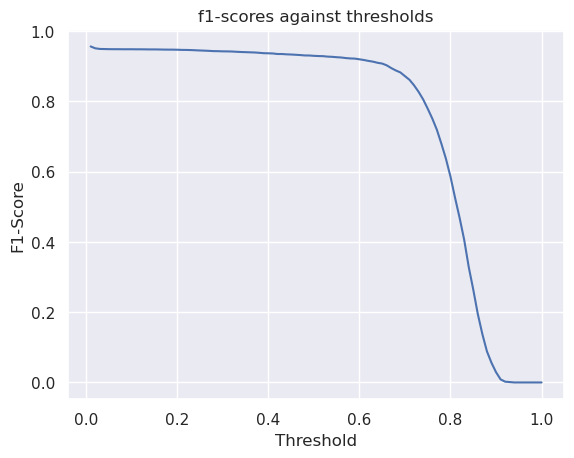

In [36]:
f1_score_values = [] # to stores f1-score values at each threshold

for thd in thresholds: 
    metrics = calculate_metrics(df1["IoU"], thd)
    f1_score = metrics[2] # find the f1-score for the threshold
    f1_score_values.append(f1_score)

# Plot the curve 
plt.title("f1-scores against thresholds")
plt.plot(thresholds, f1_score_values)
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.show()

**Find optimum threshold using precision-recall curve**

First, I will calculate the Minimum Average Precision

Since we are working with one class(Mononukleäre Zelle) - Area under precision-recall curve is the mAP. 

I will consider where precision $\approx$ recall as the optimum threshold 

In [37]:
precision_values = [] # to stores precision values at each threshold
recall_values = [] # to stores recall values at each threshold

for thd in thresholds: 
    metrics = calculate_metrics(df1["IoU"], thd)
    precision_values.append(metrics[0])
    recall_values.append(metrics[1])

# Calculate mAp
np.trapezoid(precision_values, recall_values)

np.float64(-0.07030110792522157)

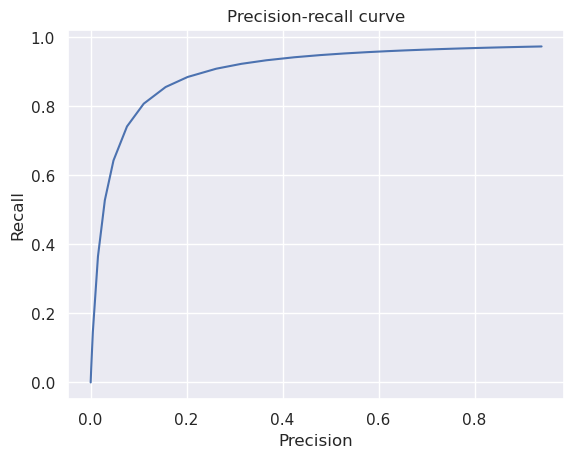

In [38]:
# Plot the precision recall curve 
plt.title("Precision-recall curve")
plt.plot(precision_values, recall_values)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

In [39]:
metrics_df = pd.DataFrame({
    "precision": precision_values,
    "recall": recall_values,
    "f1_score": f1_score_values
})

# Calculate difference between precision and recall values 
metrics_df["precision-recall"] = abs(metrics_df["precision"]-metrics_df["recall"])

# remove all rows where precision or recall == 0 
metrics_df = metrics_df[(metrics_df["precision"]!=0)|(metrics_df["recall"]!=0)]
# metrics_df[(metrics_df["precision"]!=0)|(metrics_df["recall"] != 0)]


metrics_df.head()

,precision,recall,f1_score,precision-recall
0,0.939505,0.972619,0.955775,0.033114
1,0.929657,0.972337,0.950518,0.042680
2,0.926280,0.972239,0.948703,0.045958
3,0.925718,0.972222,0.948400,0.046505
4,0.925155,0.972206,0.948097,0.047051


In [40]:
metrics_df["precision-recall"].max()

0.6989997164591558

In [41]:
metrics_df["precision-recall"].min()

0.02027058713187019

In [42]:
# find where precision is approximately equal to recall
metrics_df[metrics_df["precision-recall"]==metrics_df["precision-recall"].min()]

,precision,recall,f1_score,precision-recall
92,0.000563,0.020833,0.001096,0.020271


In [43]:
At the threshold where 

SyntaxError: invalid syntax (1744892709.py, line 1)